<ul><li>American Gut Project
</li><li>License: BSD
</li><li>Last Update: April 2014
</li></ul>

The following libraries will need to be installed
</li><li><a href="https://www.python.org/download/releases/2.7/">Python 2.7</a>
</li><li><a href="http://biom-format.org/index.html">BIOM 2.0 or later</a>
</li><li><a href="http://www.numpy.org/">Numpy 1.5.1</a>
</li><li><a href="http://www.scipy.org">SciPy</a>
</li><li><a href="http://pandas.pydata.org">pandas</a>
</li><li><a href="http://statsmodels.sourceforge.net/">statsmodels</a>
</li><li><a href="http://scikit-bio.org/">scikit bio development version</a>
</li><li><a href="http://matplotlib.org/">matplotlib</a>
</li></ul>

Compositional data analysis is a mathematical framework intended to analyze datasets of proportions.  Analyzing datasets of proportions are full of caveats.

For instance, consider a simple example where there are three types of bacteria: A, B, and C.
Initially, all of the bacteria have the same populations.  So the initial sample proportion is $A=1/3$, $B=1/3$, $C=1/3$.

After a period of time, another sample was taken.  This time, the sample proportion was $A=1/2$, $B=1/4$, $C=1/4$.

What happened?

One possibility was that the population of $A$ doubled while the other populations remained the same.
Another possibility was that the population of $B$ and $C$ were halved while the population of $A$ remained constant.
Turns out there are an infinite number of possibilities that could explain the difference in proportions between these two samples.  

Unfortunately, when it comes to microbiome data, all of the datasets are measures of proportions.  The total bacteria count is unknown and one of the most informative measures is the sample estimate of the bacterial proportions.

Compositional data analysis provides an alternative framework that facilities the comparison between samples. This tutorial will illustrate how these analyses can be applied to the American Gut dataset.

In [143]:
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import statsmodels.api as sm
from biom import load_table
from skbio.stats.composition import *
from americangut.biplot import make_biplot
import matplotlib.pyplot as plt
%matplotlib inline

Let's load the biom table and the metadata

In [144]:
table = load_table('../data/AG/AG_100nt.biom')
table

22742 x 4827 <class 'biom.table.Table'> with 1891517 nonzero entries (1% dense)

In [145]:
metadata = pd.read_table("../data/AG/AG_100nt.txt", index_col=0, low_memory=False, na_values=['no_data', 'unknown'])

Since we are only analyzing fecal samples, let's filter out the non-fecal samples

In [146]:
metadata = metadata[metadata['BODY_PRODUCT']=='UBERON:feces']

In [147]:
meta_filter = lambda val, id_, md: id_ in metadata.index
table = table.filter(meta_filter, axis='sample')

In [148]:
# Filters out samples and OTUs with less than 1000 reads
read_filter = lambda val, id_, md: np.sum(val) > 1000
table = table.filter(read_filter, axis='observation')
table = table.filter(read_filter, axis='sample')
table

1834 x 3405 <class 'biom.table.Table'> with 1222724 nonzero entries (19% dense)

Since there are many OTUs, we'll want to instead analyze the family level.  This will not only speed up calculations, but will also make the biplot a bit more clear.

In [149]:
family_idx=5
collapse_f = lambda id_, md: '; '.join(md['taxonomy'][:family_idx])
family_table = table.collapse(collapse_f, axis='observation')
family_table

98 x 3405 <class 'biom.table.Table'> with 132242 nonzero entries (39% dense)

In [150]:
norm_func = lambda data, id_, md: data / sum(data)
norm_family_table = family_table.transform(norm_func, axis='sample')
norm_family_table

98 x 3405 <class 'biom.table.Table'> with 132242 nonzero entries (39% dense)

Now we'll are going to start making biplots

First, we are going to utilize a singular value decomposition. See page 36 in reference [2] for more details.


In [151]:
mat = norm_family_table._get_sparse_data().toarray().transpose()
mat = multiplicative_replacement(mat)
mat = centralize(mat)
mat = clr(mat)

In [152]:
L, K, M = np.linalg.svd(mat)

In [153]:
n, _ = L.shape
# Now extract only the first 2 eigenvectors
_k = K[:2]
samp_pca = L[:,:2] * np.sqrt(n-1)
feat_pca = np.multiply(M[:2,:],(_k.reshape(2,1) / np.sqrt(n-1))) 
K[np.isnan(K)]=0
print "%f of the variability is explained"%(sum(_k**2 )/sum(K**2))

0.190713 of the variability is explained


A cartesian to polar coordination conversion is going to be added to aid with the interpretation

In [154]:
def cart2polar(x, y):
    rho = np.sqrt(x**2 + y**2)
    phi = np.degrees(np.arctan2(y, x))
    return (rho, phi)

Pandas dataframes are going to be used, just to keep our data organized

In [155]:
samp_plr = cart2polar(np.ravel(samp_pca[:,0]), np.ravel(samp_pca[:,1]))
feat_plr = cart2polar(np.ravel(feat_pca[0,:]), np.ravel(feat_pca[1,:]))
samp_df = pd.DataFrame({'PCA1':np.ravel(samp_pca[:,0]),
                        'PCA2':np.ravel(samp_pca[:,1]),
                        'radius':samp_plr[0],
                        'degrees':samp_plr[1]},
                        index=family_table.ids(axis='sample'))

#Include days variable in samp_df
samp_df = pd.merge(samp_df, metadata,
                   left_index=True,right_index=True)

samp_df = samp_df.sort('degrees')

feat_df = pd.DataFrame({'PCA1':np.ravel(feat_pca[0,:]),
                        'PCA2':np.ravel(feat_pca[1,:]),
                        'radius':feat_plr[0],
                        'degrees':feat_plr[1]},
                        index = family_table.ids(axis='observation'))
feat_df = feat_df.sort('degrees')

We'll also want to parse the taxonomies into the `feat_df` dataframe.  This will also us to color the biplot by taxonomy.

In [156]:
taxa = family_table.ids(axis='observation')

taxa_df = pd.DataFrame()
taxa_df["family"] = map( lambda x: x.split('; ')[4] if len(x.split('; '))>4 else "f__", taxa)
taxa_df["order"] = map( lambda x: x.split('; ')[3]  if len(x.split('; '))>3 else "o__", taxa)
taxa_df["class"] = map( lambda x: x.split('; ')[2]  if len(x.split('; '))>2 else "c__", taxa)
taxa_df["phylum"] = map( lambda x: x.split('; ')[1] if len(x.split('; '))>1 else "p__", taxa)
taxa_df["kingdom"] = map( lambda x: x.split('; ')[0], taxa)

taxa_df.index = taxa
feat_df = pd.merge(feat_df, taxa_df,
                   left_index=True, right_index=True) 

Now we're going to construct the biplot

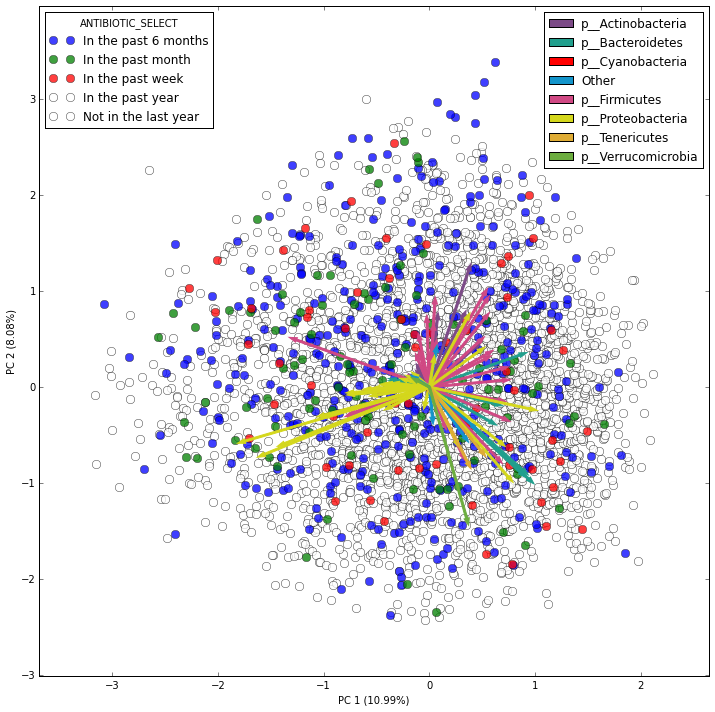

In [157]:
fig = make_biplot(samp_df,feat_df,
                  metavar="ANTIBIOTIC_SELECT",
                  eigvals=K,
                  sample_cmap={'Not in the last year':'w',
                               'In the past week':'r',
                               'In the past month':'g',
                               'In the past 6 months':'b',
                               'In the past year':'w'
                              },
                  zorder_dict={'Not in the last year':1,
                               'In the past year':2,
                               'In the past 6 months':3,
                               'In the past month':4,
                               'In the past week':5},
                  otu_cmap={'p__Bacteroidetes':'#219F8D',
                            'p__Actinobacteria':'#7C4A87',
                            'p__Firmicutes':'#D04984',
                            'p__Proteobacteria':'#D4D71C',
                            'p__Verrucomicrobia':'#6CAD3F',
                            'p__Derferribateres':'#CF5635',
                            'p__Cyanobacteria':'#FF0000',
                            'p__Tenericutes':'#DFAC35',
                            'Other':'#1394CA'},
                  alpha=0.5,
                  sample_legend=2,
                  otu_legend=1)

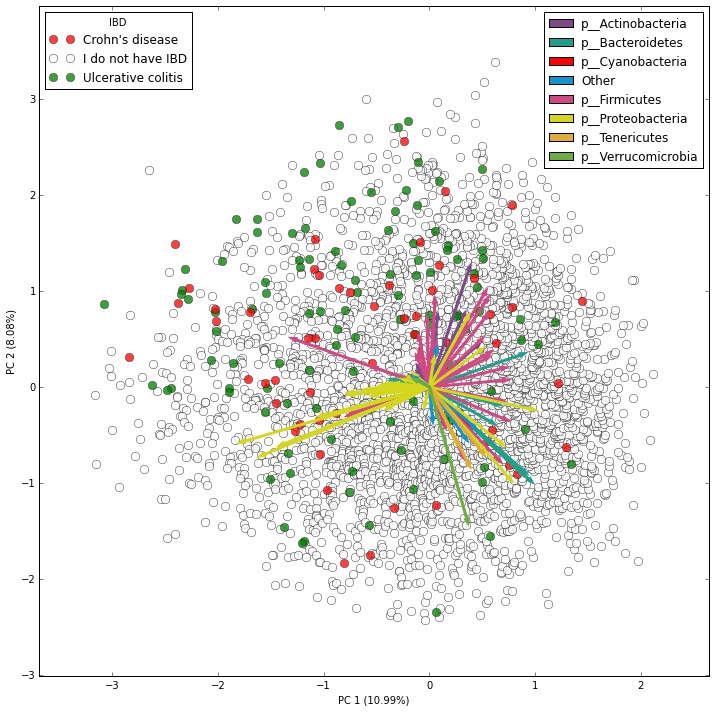

In [158]:
plt.figure()
fig = make_biplot(samp_df,feat_df,
                  metavar="IBD",
                  eigvals=K,
                  sample_cmap={"Crohn's disease":'r',
                               'Ulcerative colitis':'g',
                               'I do not have IBD':'w'
                              },
                  zorder_dict={"Crohn's disease":3,
                               'Ulcerative colitis':2,
                               'I do not have IBD':1
                              },
                  otu_cmap={'p__Bacteroidetes':'#219F8D',
                            'p__Actinobacteria':'#7C4A87',
                            'p__Firmicutes':'#D04984',
                            'p__Proteobacteria':'#D4D71C',
                            'p__Verrucomicrobia':'#6CAD3F',
                            'p__Derferribateres':'#CF5635',
                            'p__Cyanobacteria':'#FF0000',
                            'p__Tenericutes':'#DFAC35',
                            'Other':'#1394CA'},
                  alpha=0.5,
                  sample_legend=2,
                  otu_legend=1)

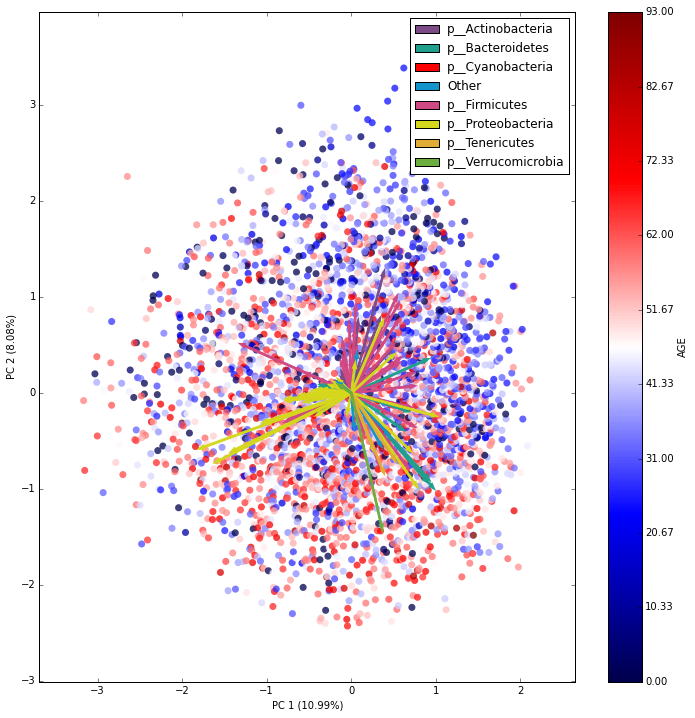

In [159]:
plt.figure()
fig = make_biplot(samp_df,feat_df,
                  metavar="AGE",
                  eigvals=K,
                  otu_cmap={'p__Bacteroidetes':'#219F8D',
                            'p__Actinobacteria':'#7C4A87',
                            'p__Firmicutes':'#D04984',
                            'p__Proteobacteria':'#D4D71C',
                            'p__Verrucomicrobia':'#6CAD3F',
                            'p__Derferribateres':'#CF5635',
                            'p__Cyanobacteria':'#FF0000',
                            'p__Tenericutes':'#DFAC35',
                            'Other':'#1394CA'},
                  alpha=0.5,
                  sample_legend=2,
                  otu_legend=1)

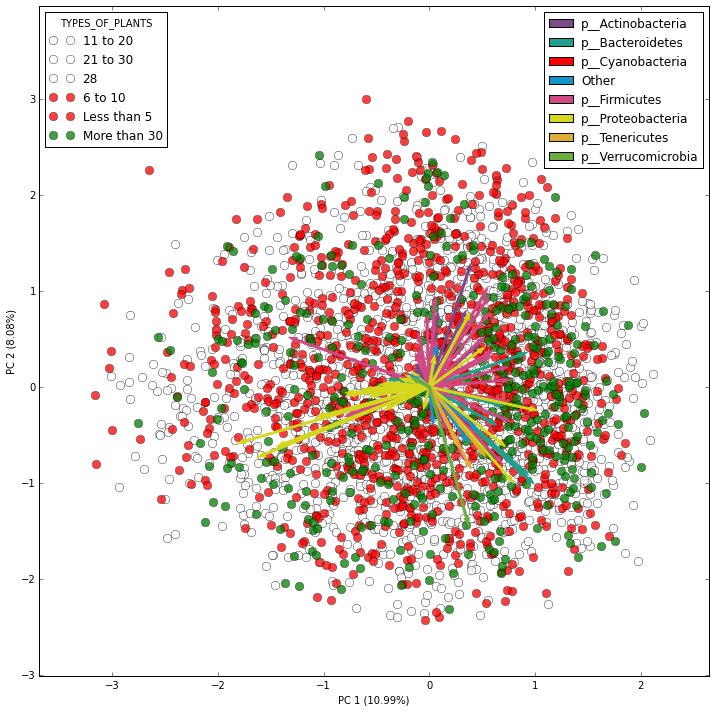

In [160]:
plt.figure()
fig = make_biplot(samp_df,feat_df,
                  metavar="TYPES_OF_PLANTS",
                  eigvals=K,
                  sample_cmap={'Less than 5':'r',
                             '6 to 10':'r',
                             '11 to 20':'w',
                             '21 to 30':'w',
                             '28':'w',
                             'More than 30':'g'
                            },
                  otu_cmap={'p__Bacteroidetes':'#219F8D',
                            'p__Actinobacteria':'#7C4A87',
                            'p__Firmicutes':'#D04984',
                            'p__Proteobacteria':'#D4D71C',
                            'p__Verrucomicrobia':'#6CAD3F',
                            'p__Derferribateres':'#CF5635',
                            'p__Cyanobacteria':'#FF0000',
                            'p__Tenericutes':'#DFAC35',
                            'Other':'#1394CA'},
                  alpha=0.5,
                  sample_legend=2,
                  otu_legend=1)

Now, look at the healthy subset

In [161]:
# Defines the filtering functions for alpha diversity
subset_f = {'AGE': lambda x: 19 < x and not np.isnan(x),          
            'DIABETES': lambda x: x == 'I do not have diabetes',
            'IBD': lambda x: x == 'I do not have IBD',
            'ANTIBIOTIC_SELECT': lambda x: x == 'Not in the last year',
            'BMI': lambda x: 18.5 <= x < 30 and not np.isnan(x)}

# Determines which samples meet the requirements of the categories
new_bin = {}
for cat, f in subset_f.iteritems():
    new_bin[cat] = metadata[cat].apply(f)

# Builds up the new binary dataframe
bin_frame = pd.DataFrame(new_bin)

# Adds a column to the current dataframe to look at the subset
bin_series = pd.DataFrame(new_bin).all(1)

# Filters the original mapping file so only samples which satisfy the criteria are included in the new metadata file.
healthy_metadata = metadata.groupby(bin_series).get_group(True)

In [162]:
meta_filter = lambda val, id_, md: id_ in healthy_metadata.index
norm_func = lambda data, id_, md: data / sum(data)
healthy_family_table = family_table.filter(meta_filter, axis='sample')
norm_healthy_family_table = healthy_family_table.transform(norm_func, axis='sample')
norm_healthy_family_table

98 x 1501 <class 'biom.table.Table'> with 60111 nonzero entries (40% dense)

In [163]:
mat = norm_healthy_family_table._get_sparse_data().toarray().transpose()
mat = multiplicative_replacement(mat)
mat = centralize(mat)
mat = clr(mat)

In [164]:
L, K, M = np.linalg.svd(mat)

In [165]:
n, _ = L.shape
# Now extract only the first 2 eigenvectors
_k = K[:2]
samp_pca = L[:,:2] * np.sqrt(n-1)
feat_pca = np.multiply(M[:2,:],(_k.reshape(2,1) / np.sqrt(n-1))) 
K[np.isnan(K)]=0
print "%f of the variability is explained"%(sum(_k**2 )/sum(K**2))

0.189264 of the variability is explained


In [166]:
samp_plr = cart2polar(np.ravel(samp_pca[:,0]), np.ravel(samp_pca[:,1]))
feat_plr = cart2polar(np.ravel(feat_pca[0,:]), np.ravel(feat_pca[1,:]))
samp_df = pd.DataFrame({'PCA1':np.ravel(samp_pca[:,0]),
                        'PCA2':np.ravel(samp_pca[:,1]),
                        'radius':samp_plr[0],
                        'degrees':samp_plr[1]},
                        index=family_table.ids(axis='sample'))

#Include days variable in samp_df
samp_df = pd.merge(samp_df, metadata,
                   left_index=True,right_index=True)

samp_df = samp_df.sort('degrees')

feat_df = pd.DataFrame({'PCA1':np.ravel(feat_pca[0,:]),
                        'PCA2':np.ravel(feat_pca[1,:]),
                        'radius':feat_plr[0],
                        'degrees':feat_plr[1]},
                        index = family_table.ids(axis='observation'))
feat_df = feat_df.sort('degrees')
taxa = family_table.ids(axis='observation')

taxa_df = pd.DataFrame()
taxa_df["family"] = map( lambda x: x.split('; ')[4] if len(x.split('; '))>4 else "f__", taxa)
taxa_df["order"] = map( lambda x: x.split('; ')[3]  if len(x.split('; '))>3 else "o__", taxa)
taxa_df["class"] = map( lambda x: x.split('; ')[2]  if len(x.split('; '))>2 else "c__", taxa)
taxa_df["phylum"] = map( lambda x: x.split('; ')[1] if len(x.split('; '))>1 else "p__", taxa)
taxa_df["kingdom"] = map( lambda x: x.split('; ')[0], taxa)

taxa_df.index = taxa
feat_df = pd.merge(feat_df, taxa_df,
                   left_index=True, right_index=True) 

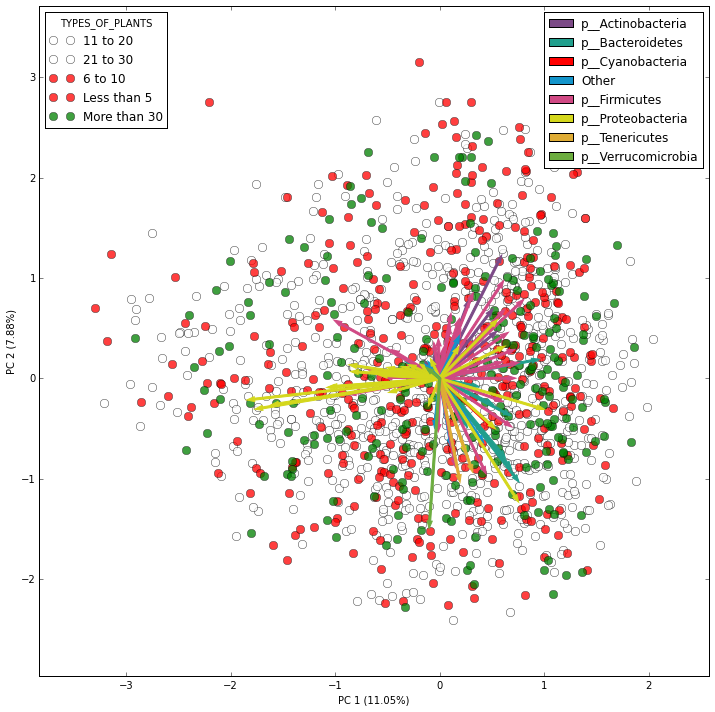

In [167]:
plt.figure()
fig = make_biplot(samp_df,feat_df,
                  metavar="TYPES_OF_PLANTS",
                  eigvals=K,
                  spread='scatter',
                  sample_cmap={'Less than 5':'r',
                             '6 to 10':'r',
                             '11 to 20':'w',
                             '21 to 30':'w',
                             '28':'w',
                             'More than 30':'g'
                            },
                  otu_cmap={'p__Bacteroidetes':'#219F8D',
                            'p__Actinobacteria':'#7C4A87',
                            'p__Firmicutes':'#D04984',
                            'p__Proteobacteria':'#D4D71C',
                            'p__Verrucomicrobia':'#6CAD3F',
                            'p__Derferribateres':'#CF5635',
                            'p__Cyanobacteria':'#FF0000',
                            'p__Tenericutes':'#DFAC35',
                            'Other':'#1394CA'},
                  alpha=0.5,
                  sample_legend=2,
                  otu_legend=1)

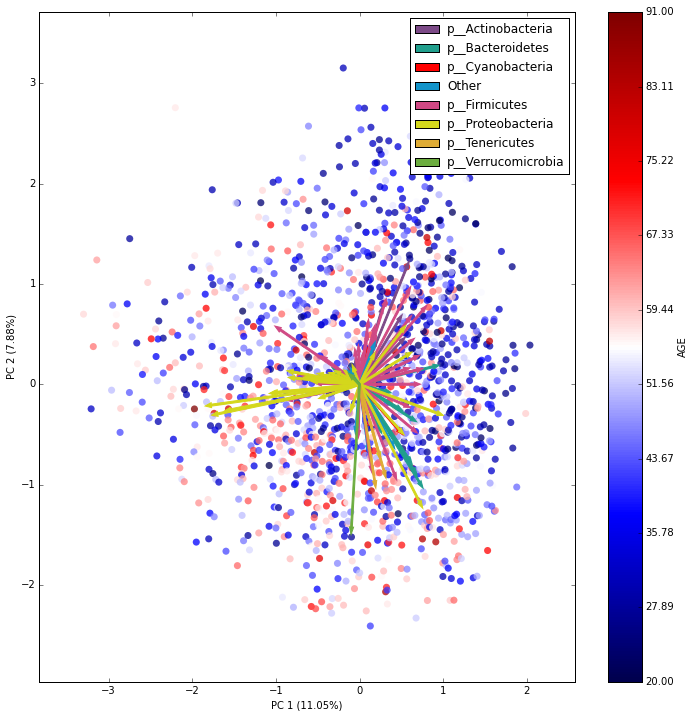

In [168]:
plt.figure()
fig = make_biplot(samp_df,feat_df,
                  metavar="AGE",
                  eigvals=K,
                  otu_cmap={'p__Bacteroidetes':'#219F8D',
                            'p__Actinobacteria':'#7C4A87',
                            'p__Firmicutes':'#D04984',
                            'p__Proteobacteria':'#D4D71C',
                            'p__Verrucomicrobia':'#6CAD3F',
                            'p__Derferribateres':'#CF5635',
                            'p__Cyanobacteria':'#FF0000',
                            'p__Tenericutes':'#DFAC35',
                            'Other':'#1394CA'},
                  alpha=0.5,
                  sample_legend=2,
                  otu_legend=1)

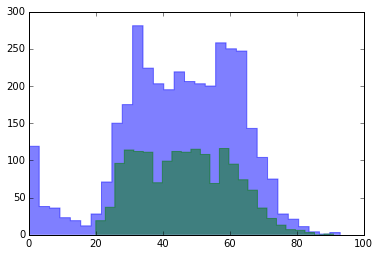

In [199]:
n, bins, patches = plt.hist(metadata['AGE'].dropna(), 30, alpha=0.5,
                            histtype='step', stacked=True, fill=True)
n, bins, patches = plt.hist(healthy_metadata['AGE'].dropna(), 25, alpha=0.5,
                            histtype='step', stacked=True, fill=True)

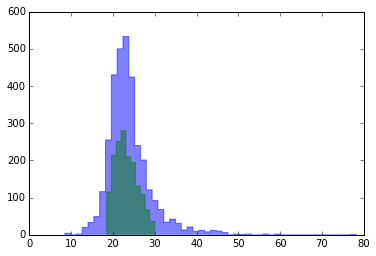

In [195]:
n, bins, patches = plt.hist(metadata['BMI'].dropna(), 50, alpha=0.5,
                            histtype='step', stacked=True, fill=True)
n, bins, patches = plt.hist(healthy_metadata['BMI'].dropna(), 10, alpha=0.5,
                            histtype='step', stacked=True, fill=True)